## Supervised Learning
## Project: Finding Donors for *CharityML*

## Getting Started

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

## Exploring the Data

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration

In [2]:
# Total number of records
n_records = len(data)

# Number of records where individual's income is more than $50,000
n_greater_50k = data["income"].value_counts()[1]

# Number of records where individual's income is at most $50,000
n_at_most_50k = data["income"].value_counts()[0]

# Percentage of individuals whose income is more than $50,000
greater_percent =  ((n_greater_50k/n_records) *100).round(4)

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.7844%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 


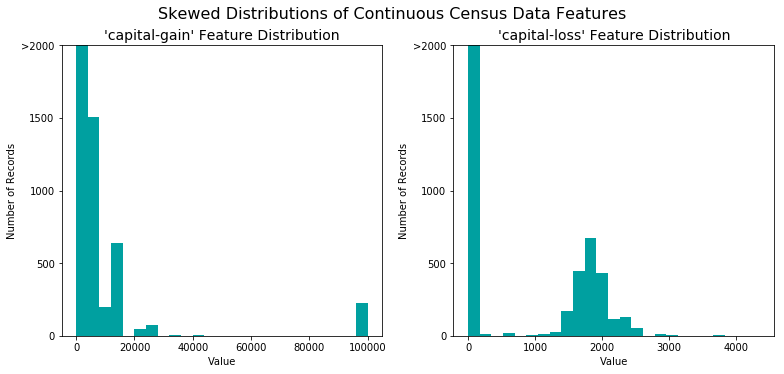

In [3]:
# Split the data into features and target label
income_raw= data["income"]
features_raw= data.drop("income", axis=1)

# Visualize skewed continuous features of original data
vs.distribution(data)

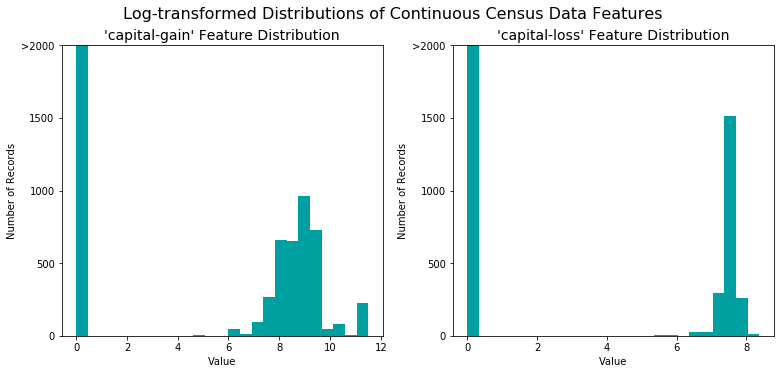

In [4]:
# Log-transform the skewed features
skewed=['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data=features_raw)
features_log_transformed[skewed]=features_log_transformed[skewed].apply(lambda x: np.log(x+1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income_raw = income_raw.map({'<=50K':0, '>50K':1})

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
# print encoded

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [7]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income_raw, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


----
## Evaluating Model Performance

### Model Application

### SVC ###
   <br /> Real life application: loan default problem
   <br /> Strengths:The usage of a regularization parameter provides avoiding from over-fitting. 
   <br /> Weaknesses:Training with large dataset can be time consuming.
   <br /> This dataset 13 predictors and some of them are mutiple level categorical variables. SVC model can avoiding overfitting.
### Decsion Trees ###
   <br /> Real life application: finding out the most propriate customers.
   <br /> Strengths: Decision trees can be used with both continuous and categorical variables. It can be used for non-linear relationships 
   <br /> Weaknesses: Over fitting. 
   <br /> This dataset has both continuous and categorical variables.
### Ramdon Forest ###
   <br /> Real life application:hotel bookings cancellation forecast.
   <br /> Strengths: Low Bias, moderate variance
   <br /> Weaknesses:It is like a black box.
   <br /> This model can provide analysis on importance of predictors.

### Implementation - Creating a Training and Predicting Pipeline

 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [9]:

from sklearn.metrics import accuracy_score, fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end-start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
            
    #  Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = np.sum(predictions_train==y_train[:300])/300
        
    #  Compute accuracy on test set using accuracy_score()
    results['acc_test'] = np.sum(predictions_test==y_test)/len(y_test)
    
    #  Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train,0.5)
        
    #  Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test,predictions_test,0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation

- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.


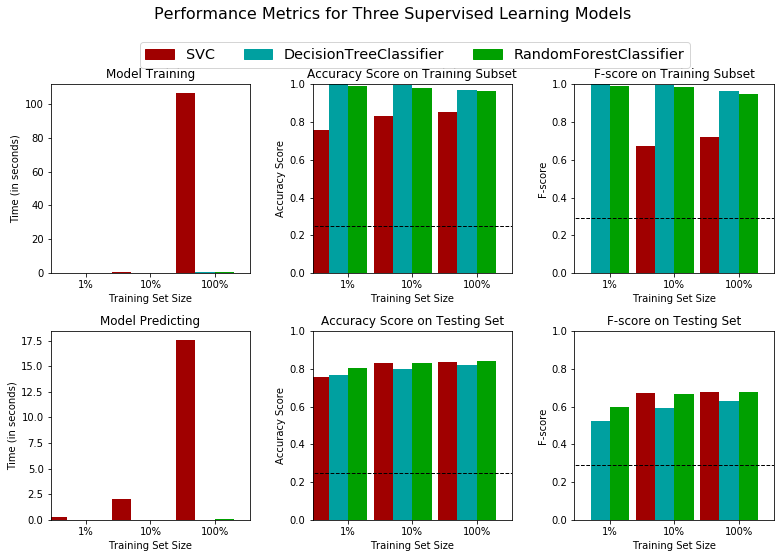

In [10]:
# Import the three supervised learning models from sklearn
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Initialize the three models
clf_A = SVC(random_state=2)
clf_B = DecisionTreeClassifier(random_state=2)
clf_C = RandomForestClassifier(random_state=2)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(len(y_train)*0.1)
samples_1 = int(len(y_train)*0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results

### Implementation: Model Tuning

- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.


In [11]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier
clf = RandomForestClassifier(random_state=2)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'max_depth':[3,5,7],"n_estimators":[200,400,600], 'max_features': ['auto', 'sqrt', 'log2']}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8405
F-score on testing data: 0.6777

Optimized Model
------
Final accuracy score on the testing data: 0.8471
Final F-score on the testing data: 0.7096


#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |       0.8405      |     0.8471      |
| F-score        |       0.6777      |     0.7096      |


----
## Feature Importance

### Implementation - Extracting Feature Importance

 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

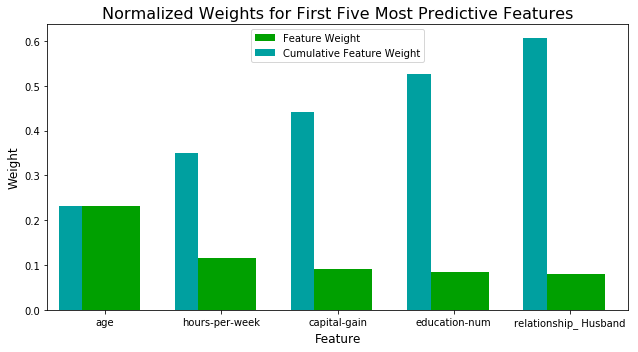

In [14]:
# Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import RandomForestClassifier

# Train the supervised model on the training set using .fit(X_train, y_train)
model = RandomForestClassifier().fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_ 

# Plot
vs.feature_plot(importances, X_train, y_train)

### Feature Selection 

In [15]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8471
F-score on testing data: 0.7096

Final Model trained on reduced data
------
Accuracy on testing data: 0.8404
F-score on testing data: 0.6948
